# Predicting Tree Survival Using Neural Networks and Survival Analysis
This project predicts tree survival status and survival time using neural networks, clustering, and Kaplan-Meier survival analysis. Biological and environmental features are used to estimate survival probabilities, classify survival status, and provide survival time estimates.

In [254]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from lifelines import KaplanMeierFitter

import torch 
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading and Preprocessing
The dataset is loaded, and missing values are handled. Features are scaled for clustering and neural network processing.

In [255]:
data = pd.read_csv('./Tree_Data.csv')

print(data.head())

     No  Plot Subplot         Species  Light_ISF Light_Cat  Core  \
0   126     1       C  Acer saccharum       0.11       Med  2017   
1    11     1       C    Quercus alba       0.11       Med  2017   
2    12     1       C   Quercus rubra       0.11       Med  2017   
3  2823     7       D  Acer saccharum       0.08       Med  2016   
4  5679    14       A  Acer saccharum       0.06       Low  2017   

              Soil Adult      Sterile  ...   AMF   EMF Phenolics Lignin   NSC  \
0  Prunus serotina     I  Non-Sterile  ... 22.00   NaN     -0.56  13.86 12.15   
1    Quercus rubra   970  Non-Sterile  ... 15.82 31.07      5.19  20.52 19.29   
2  Prunus serotina     J  Non-Sterile  ... 24.45 28.19      3.36  24.74 15.01   
3  Prunus serotina     J  Non-Sterile  ... 22.23   NaN     -0.71  14.29 12.36   
4  Prunus serotina   689  Non-Sterile  ... 21.15   NaN     -0.58  10.85 11.20   

   Census   Time  Event  Harvest  Alive  
0       4  14.00   1.00      NaN    NaN  
1      33 115.50   0

In [256]:
data.shape

(2783, 24)

In [257]:
# Checking for null values
print(data.isnull().sum())

No              0
Plot            0
Subplot         0
Species         0
Light_ISF       0
             ... 
Census          0
Time            0
Event           1
Harvest      2079
Alive        2292
Length: 24, dtype: int64


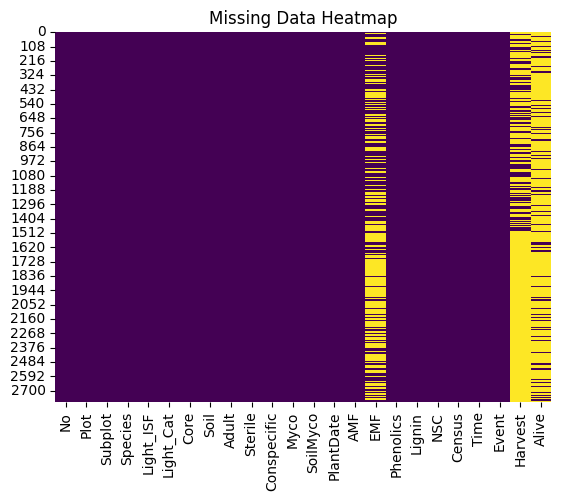

In [258]:
# Visualizing missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [259]:
# Impute Event with the mode
data['Event'].fillna(data['Event'].mode()[0], inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_10828\3862981972.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Event'].fillna(data['Event'].mode()[0], inplace=True)


In [260]:
# Impute EMF with the mean
data['EMF'].fillna(data['EMF'].mean(), inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_10828\1828988850.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['EMF'].fillna(data['EMF'].mean(), inplace=True)


In [261]:
# Drop columns with high missing data
data.drop(columns=['Harvest', 'Alive'], inplace=True)

In [262]:
print(data.isnull().sum())

No           0
Plot         0
Subplot      0
Species      0
Light_ISF    0
            ..
Lignin       0
NSC          0
Census       0
Time         0
Event        0
Length: 22, dtype: int64


In [263]:
data.shape

(2783, 22)

In [264]:
data

,No,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Adult,Sterile,...,SoilMyco,PlantDate,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event
0,126,1,C,Acer saccharum,0.11,Med,2017,Prunus serotina,I,Non-Sterile,...,AMF,6/11/18,22.00,26.48,-0.56,13.86,12.15,4,14.00,1.00
1,11,1,C,Quercus alba,0.11,Med,2017,Quercus rubra,970,Non-Sterile,...,EMF,5/25/18,15.82,31.07,5.19,20.52,19.29,33,115.50,0.00
2,12,1,C,Quercus rubra,0.11,Med,2017,Prunus serotina,J,Non-Sterile,...,AMF,5/31/18,24.45,28.19,3.36,24.74,15.01,18,63.00,1.00
3,2823,7,D,Acer saccharum,0.08,Med,2016,Prunus serotina,J,Non-Sterile,...,AMF,6/11/18,22.23,26.48,-0.71,14.29,12.36,4,14.00,1.00
4,5679,14,A,Acer saccharum,0.06,Low,2017,Prunus serotina,689,Non-Sterile,...,AMF,6/11/18,21.15,26.48,-0.58,10.85,11.20,4,14.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,7165,17,B,Prunus serotina,0.11,Med,2017,Populus grandidentata,891,Non-Sterile,...,EMF,6/7/18,40.89,26.48,0.83,9.15,11.88,16,56.00,1.00
2779,7217,17,D,Quercus alba,0.12,Med,2017,Acer rubrum,1468,Non-Sterile,...,AMF,5/25/18,15.47,32.82,4.88,19.01,23.50,16,56.00,1.00
2780,7306,17,D,Quercus alba,0.12,Med,2017,Quercus rubra,1454,Non-Sterile,...,EMF,5/25/18,11.96,37.67,5.51,21.13,19.10,16,56.00,1.00
2781,7771,18,D,Quercus alba,0.16,High,2017,Sterile,1297,Sterile,...,Sterile,5/17/18,16.99,22.51,4.28,19.38,21.36,33,115.50,1.00


## Exploratory Data Analysis
Visualize the data distributions and relationships between features.


In [ ]:
# Pairplot for visualizing relationships
sns.pairplot(data, hue='Event', diag_kind='kde')
plt.show()

# Check feature distributions
data.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

## Clustering Analysis
K-Means and hierarchical clustering are performed to group trees based on features. Kaplan-Meier curves are generated for each cluster.


In [204]:
# Select relevant features for clustering
features = ['AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC', 'Light_ISF']
X = data[features]
X.shape

(2783, 6)

In [205]:
# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

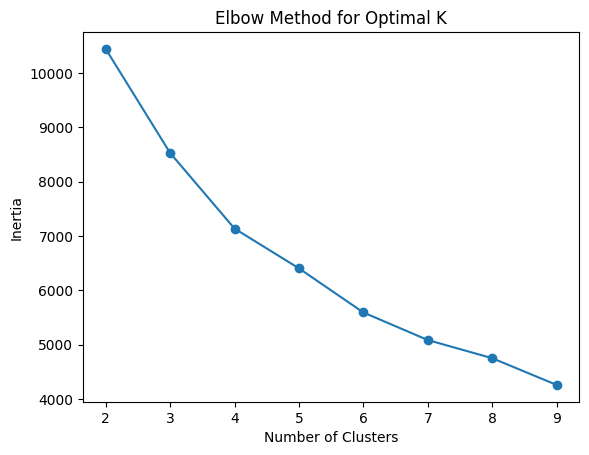

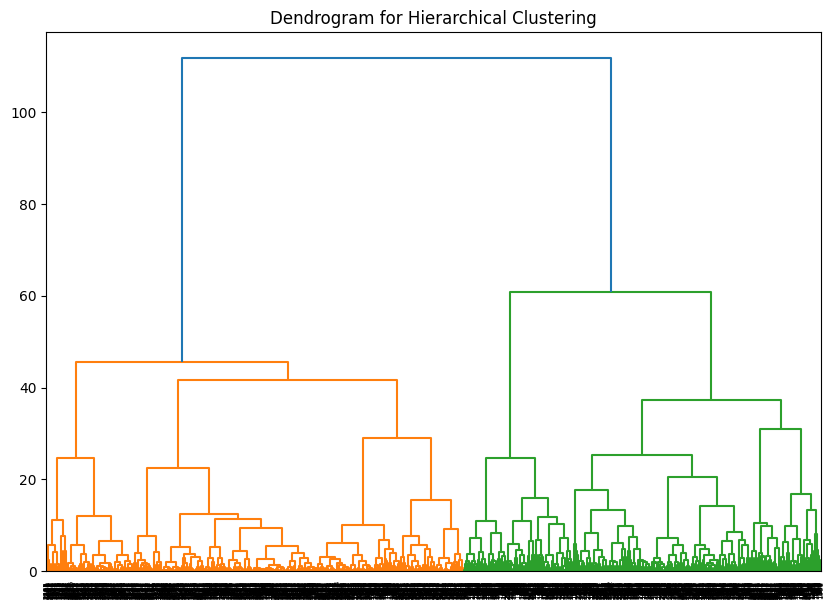

In [206]:
# K-Means Clustering
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Elbow method visualization
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Hierarchical Clustering
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

## Kaplan-Meier Survival Analysis
Kaplan-Meier survival curves are plotted for each cluster.


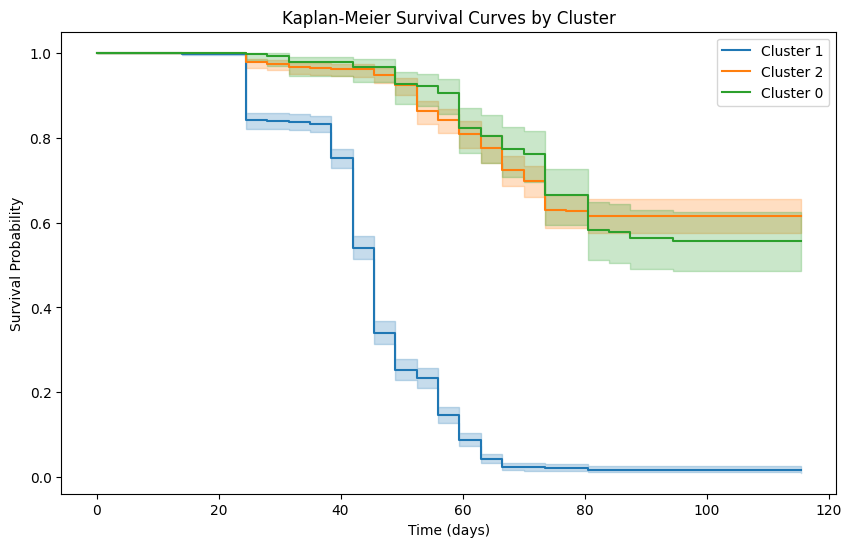

In [207]:
from lifelines import KaplanMeierFitter

# Assign cluster labels
optimal_k = 3  # Example value from elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    kmf.fit(durations=cluster_data['Time'], event_observed=cluster_data['Event'], label=f'Cluster {cluster}')
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Cluster')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

## Neural Network Implementation
A feedforward neural network is implemented to predict tree survival based on features.

In [208]:
features = ['AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC', 'Light_ISF']
X = data[features]
Y = data['Event'] 

In [209]:
X

,AMF,EMF,Phenolics,Lignin,NSC,Light_ISF
0,22.00,26.48,-0.56,13.86,12.15,0.11
1,15.82,31.07,5.19,20.52,19.29,0.11
2,24.45,28.19,3.36,24.74,15.01,0.11
3,22.23,26.48,-0.71,14.29,12.36,0.08
4,21.15,26.48,-0.58,10.85,11.20,0.06
...,...,...,...,...,...,...
2778,40.89,26.48,0.83,9.15,11.88,0.11
2779,15.47,32.82,4.88,19.01,23.50,0.12
2780,11.96,37.67,5.51,21.13,19.10,0.12
2781,16.99,22.51,4.28,19.38,21.36,0.16


In [210]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [211]:
class TreeSurvivalDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [212]:
# Create Datasets
train_dataset = TreeSurvivalDataset(X_train, Y_train)
test_dataset = TreeSurvivalDataset(X_test, Y_test)
dev_dataset = TreeSurvivalDataset(X_dev, Y_dev)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)


In [213]:
# Create datasets
train_dataset = TreeSurvivalDataset(X_train, Y_train)
test_dataset = TreeSurvivalDataset(X_test, Y_test)
dev_dataset = TreeSurvivalDataset(X_dev, Y_dev)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [214]:
# Define the neural network
class TreeSurvivalNN(NN.Module):
    def __init__(self, input_size):
        super(TreeSurvivalNN, self).__init__()
        self.model = NN.Sequential(
        NN.Linear(input_size, 64),
        NN.ReLU(),
        NN.Dropout(0.3),          
        NN.Linear(64, 1),
        NN.Sigmoid()
)

    def forward(self, x):
        return self.model(x)

In [215]:

# Instantiate the model
input_size = X_train.shape[1]
model = TreeSurvivalNN(input_size)


In [216]:
import torch.optim as optim

# Loss function and optimizer
criterion = NN.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

## Training and Evaluation
The neural network is trained, and predictions are evaluated against the test set.


In [ ]:
num_epochs = 50
best_dev_loss = float('inf')  # For early stopping

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(batch_features).squeeze()  # Forward pass
        loss = criterion(outputs, batch_labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    dev_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in dev_loader:
            outputs = model(batch_features).squeeze()
            loss = criterion(outputs, batch_labels)
            dev_loss += loss.item()

    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Dev Loss: {dev_loss/len(dev_loader):.4f}")

    # Save the best model
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), "best_tree_survival_model.pth")


Epoch 1/50, Train Loss: 0.9630, Dev Loss: 0.5333
Epoch 2/50, Train Loss: 0.6874, Dev Loss: 0.5102
Epoch 3/50, Train Loss: 0.5965, Dev Loss: 0.4907
Epoch 4/50, Train Loss: 0.5503, Dev Loss: 0.4824
Epoch 5/50, Train Loss: 0.5264, Dev Loss: 0.4745
Epoch 6/50, Train Loss: 0.5052, Dev Loss: 0.4572
Epoch 7/50, Train Loss: 0.5016, Dev Loss: 0.4504
Epoch 8/50, Train Loss: 0.4991, Dev Loss: 0.4551
Epoch 9/50, Train Loss: 0.4849, Dev Loss: 0.4569
Epoch 10/50, Train Loss: 0.4821, Dev Loss: 0.4458
Epoch 11/50, Train Loss: 0.4791, Dev Loss: 0.4297
Epoch 12/50, Train Loss: 0.4803, Dev Loss: 0.4345
Epoch 13/50, Train Loss: 0.4713, Dev Loss: 0.4206
Epoch 14/50, Train Loss: 0.4693, Dev Loss: 0.4133
Epoch 15/50, Train Loss: 0.4621, Dev Loss: 0.4196
Epoch 16/50, Train Loss: 0.4621, Dev Loss: 0.4137
Epoch 17/50, Train Loss: 0.4617, Dev Loss: 0.4084
Epoch 18/50, Train Loss: 0.4622, Dev Loss: 0.4134
Epoch 19/50, Train Loss: 0.4599, Dev Loss: 0.4203
Epoch 20/50, Train Loss: 0.4583, Dev Loss: 0.4061
Epoch 21/

In [231]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features).squeeze()
        y_pred_list.extend((outputs >= 0.5).int().tolist())
        y_true_list.extend(batch_labels.tolist())

# Evaluate predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(y_true_list, y_pred_list)
precision = precision_score(y_true_list, y_pred_list)
recall = recall_score(y_true_list, y_pred_list)
conf_matrix = confusion_matrix(y_true_list, y_pred_list)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8381
Precision: 0.9103
Recall: 0.8049
Confusion Matrix:
[[101  13]
 [ 32 132]]


## Predict Survival Time
Estimate survival time for each tree using Kaplan-Meier survival curves and cluster assignment.


In [246]:
def estimate_survival_time(model, scaler, kmeans, kmfs, new_data):
    # Preprocess new data
    new_data_scaled = scaler.transform([new_data])

    # Assign cluster
    cluster_label = kmeans.predict(new_data_scaled)[0]

    # Retrieve Kaplan-Meier fitter for the cluster
    kmf = kmfs[cluster_label]
    median_survival_time = kmf.median_survival_time_

    # Predict survival probability
    new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        survival_probability = model(new_data_tensor).item()
        predicted_class = 1 if survival_probability >= 0.5 else 0

    return survival_probability, predicted_class, median_survival_time

In [ ]:
# Example usage
kmfs = {}
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    kmf = KaplanMeierFitter()
    kmf.fit(durations=cluster_data['Time'], event_observed=cluster_data['Event'])
    kmfs[cluster] = kmf

new_tree = [39.02, 26.48, -1.20, 8.78, 9.56, 0.047]
probability, predicted_class, survival_time = estimate_survival_time(model, scaler, kmeans, kmfs, new_tree)

print(f"Survival Probability: {1 - probability:.4f}")
print(f"Probability of Death: {1 - probability:.4f}")
print(f"Predicted Class: {'Dead' if predicted_class == 1 else 'Alive'}")
print(f"Estimated Median Survival Time: {survival_time} days")


Survival Probability: 0.1891
Probability of Death: 0.1891
Predicted Class: Dead
Estimated Median Survival Time: 45.5 days


C:\Users\PMLS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Predicting survival probabilities and classes for the test set

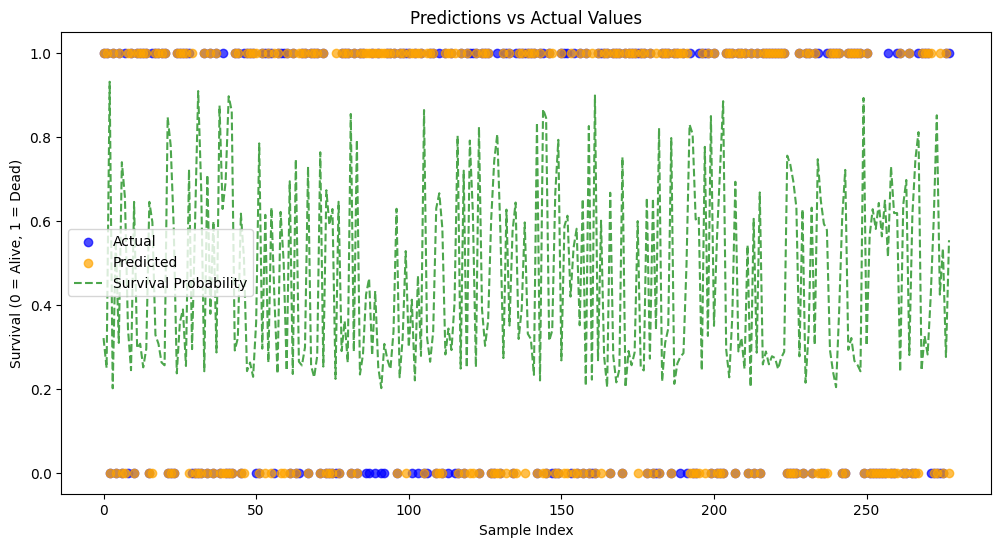

In [ ]:
# Function to predict survival probabilities, death probabilities, and classes for the test set
def test_model_on_data(model, scaler, X_test, Y_test):
    """
    Predict survival probabilities, death probabilities, and survival classes for the test set.

    Args:
        model: Trained PyTorch model.
        scaler: Fitted StandardScaler for feature normalization.
        X_test: Test features (pandas DataFrame or numpy array).
        Y_test: Test labels (pandas Series or numpy array).

    Returns:
        survival_probabilities: Survival probabilities (1 - probability of death).
        death_probabilities: Probabilities of death.
        predicted_classes: Predicted survival classes (0 = Alive, 1 = Dead).
    """
    # Preprocess test data
    X_test_scaled = scaler.transform(X_test)  # Scale the features
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Generate predictions
    model.eval()
    with torch.no_grad():
        probabilities = model(X_test_tensor).squeeze().numpy()  # Get probabilities (death probabilities)

    # Survival probabilities and predicted classes
    survival_probabilities = 1 - probabilities
    death_probabilities = probabilities
    predicted_classes = (death_probabilities >= 0.5).astype(int)

    return survival_probabilities, death_probabilities, predicted_classes

# Generate predictions on X_test
survival_probabilities, death_probabilities, predictions = test_model_on_data(model, scaler, X_test, Y_test)

# Convert Y_test to a NumPy array for comparison
Y_test_array = Y_test.to_numpy()

# Visualize predictions vs actual labels
plt.figure(figsize=(12, 6))

# Plot true values
plt.scatter(range(len(Y_test_array)), Y_test_array, label='Actual', alpha=0.7, color='blue')

# Plot predictions
plt.scatter(range(len(predictions)), predictions, label='Predicted', alpha=0.7, color='orange')

# Add a line for survival probabilities (optional, for continuous output visualization)
plt.plot(range(len(survival_probabilities)), survival_probabilities, label='Survival Probability', color='green', linestyle='--', alpha=0.7)

# Customize plot
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Survival (0 = Alive, 1 = Dead)')
plt.legend()
plt.show()


In [253]:
# Recalculate predictions based on death probability
predictions_corrected = (death_probabilities >= 0.5).astype(int)  # Classify based on death probability

# Create a DataFrame to compare results
results_df = pd.DataFrame({
    'Actual Label': Y_test.to_numpy(),                     # Actual labels
    'Predicted Label': predictions_corrected,              # Updated predictions
    'Survival Probability': survival_probabilities,      # Survival probability
    'Probability of Death': death_probabilities           # Corrected death probability
})

# Add a column to identify misclassifications
results_df['Correct Prediction'] = results_df['Actual Label'] == results_df['Predicted Label']

# Display the table
pd.set_option('display.max_rows', 20)  # Limit rows to display (adjust as needed)
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats for readability
print(results_df)

# Summarize the results
summary = results_df['Correct Prediction'].value_counts()
print("\nSummary:")
print(f"Total Samples: {len(Y_test)}")
print(f"Correct Predictions: {summary[True]}")
print(f"Incorrect Predictions: {summary[False]}")


     Actual Label  Predicted Label  Survival Probability  \
0            1.00                1                  0.32   
1            1.00                1                  0.25   
2            0.00                0                  0.93   
3            1.00                1                  0.20   
4            0.00                0                  0.55   
..            ...              ...                   ...   
273          0.00                0                  0.85   
274          0.00                1                  0.42   
275          0.00                0                  0.53   
276          1.00                1                  0.28   
277          1.00                0                  0.55   

     Probability of Death  Correct Prediction  
0                    0.68                True  
1                    0.75                True  
2                    0.07                True  
3                    0.80                True  
4                    0.45              